In [1]:
## Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Reading the train data
train_data = pd.read_csv('/kaggle/input/customer-life-time-prediction/train_BRCpofr.csv')
train = train_data.copy()
train.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [3]:
## Splitting the data into X and y
X = train.drop('cltv',axis=1)
y = train['cltv']

In [4]:
## removing id column since it won't be of any use in training machine learning model
X.drop('id',axis=1,inplace=True)

In [5]:
## finding out the names of categorical and numerical features in the data
cat_feat = [feature for feature in X.columns if X[feature].dtypes == 'O']
num_feat = [feature for feature in X.columns if feature not in cat_feat]

In [6]:
for column in X.columns:
    print(f"The unique values in the feature {column} are {X[column].unique()} (Total of {X[column].nunique()}). \n")

The unique values in the feature gender are ['Male' 'Female'] (Total of 2). 

The unique values in the feature area are ['Urban' 'Rural'] (Total of 2). 

The unique values in the feature qualification are ['Bachelor' 'High School' 'Others'] (Total of 3). 

The unique values in the feature income are ['5L-10L' 'More than 10L' '2L-5L' '<=2L'] (Total of 4). 

The unique values in the feature marital_status are [1 0] (Total of 2). 

The unique values in the feature vintage are [5 8 7 6 1 0 3 4 2] (Total of 9). 

The unique values in the feature claim_amount are [ 5790  5080  2599 ... 15361 12911 17143] (Total of 10889). 

The unique values in the feature num_policies are ['More than 1' '1'] (Total of 2). 

The unique values in the feature policy are ['A' 'C' 'B'] (Total of 3). 

The unique values in the feature type_of_policy are ['Platinum' 'Gold' 'Silver'] (Total of 3). 



In [7]:
## let's check the missing values in the data
## checking if the notable features have any missing values
# train[notable_num_feat + notable_cat_feat].isnull().sum()
miss_Val = pd.DataFrame()
miss_Val['Feature'] = num_feat + cat_feat
miss_Val['Feature_Type'] = miss_Val['Feature'].apply(lambda x: 'cat' if x in cat_feat else 'num')
miss_Val['Missing_Value_Count'] = train[num_feat + cat_feat].isnull().sum().to_numpy()
miss_Val['Missing_Value_Percentage'] = miss_Val['Missing_Value_Count'].apply(lambda x: np.round(x/train.shape[0],2)*100)
miss_Val

,Feature,Feature_Type,Missing_Value_Count,Missing_Value_Percentage
0,marital_status,num,0,0.0
1,vintage,num,0,0.0
2,claim_amount,num,0,0.0
3,gender,cat,0,0.0
4,area,cat,0,0.0
5,qualification,cat,0,0.0
6,income,cat,0,0.0
7,num_policies,cat,0,0.0
8,policy,cat,0,0.0
9,type_of_policy,cat,0,0.0


In [8]:
## replacing outliers from the column claim_amount with the median of the column
quantiles = pd.DataFrame(X['claim_amount']).quantile(np.arange(0,1,0.25)).T
quantiles = quantiles.rename(columns={0.25:'Q1', 0.50: 'Q2', 0.75:'Q3'})

quantiles['IQR'] = quantiles['Q3'] - quantiles['Q1']
quantiles['Lower_Limit'] = quantiles['Q1'] - 1.5*quantiles['IQR']
quantiles['Upper_Limit'] = quantiles['Q3'] + 1.5*quantiles['IQR']

X['claim_amount'] = np.where((X['claim_amount'] < quantiles.loc['claim_amount','Lower_Limit']) | (X['claim_amount'] > quantiles.loc['claim_amount','Upper_Limit']) & (X['claim_amount'] is not np.nan), np.nan, X['claim_amount'])

In [9]:
## dealing with the missing values in numerical and categorical features
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
X['claim_amount'] = imputer1.fit_transform(X['claim_amount'].to_numpy().reshape(-1,1))

inputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for feature in cat_feat + ['vintage', 'marital_status']:
    X[feature] = inputer2.fit_transform(X[feature].to_numpy().reshape(-1,1))

In [10]:
X

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,Male,Urban,Bachelor,5L-10L,1,5,5790.0,More than 1,A,Platinum
1,Male,Rural,High School,5L-10L,0,8,5080.0,More than 1,A,Platinum
2,Male,Urban,Bachelor,5L-10L,1,8,2599.0,More than 1,A,Platinum
3,Female,Rural,High School,5L-10L,0,7,0.0,More than 1,A,Platinum
4,Male,Urban,High School,More than 10L,1,6,3508.0,More than 1,A,Gold
...,...,...,...,...,...,...,...,...,...,...
89387,Male,Rural,High School,More than 10L,0,6,0.0,More than 1,B,Platinum
89388,Male,Urban,Bachelor,5L-10L,1,0,3897.0,More than 1,A,Platinum
89389,Female,Urban,Bachelor,5L-10L,0,4,3363.0,More than 1,B,Platinum
89390,Female,Rural,High School,2L-5L,0,8,0.0,More than 1,B,Platinum


In [11]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

oe1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe3 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
ohe = OneHotEncoder(handle_unknown='ignore',drop='first')
mms = MinMaxScaler(feature_range=(0.01,1))

## dealing with the scaling of numerical feature
X['claim_amount'] = mms.fit_transform(X['claim_amount'].to_numpy().reshape(-1,1))
## applying log-transformation to the claim amount feature
X['claim_amount'] = np.log(X['claim_amount'])

## dealing with the encoding of categorical feature
X['income']  = oe1.fit_transform(X['income'].to_numpy().reshape(-1,1))
X['qualification']  = oe2.fit_transform(X['qualification'].to_numpy().reshape(-1,1))
X['type_of_policy']  = oe3.fit_transform(X['type_of_policy'].to_numpy().reshape(-1,1))

transformer=ColumnTransformer([('ohe',ohe,['gender','area','policy','num_policies'])],remainder="passthrough",verbose_feature_names_out=False)
transformed=transformer.fit_transform(X)
X=pd.DataFrame(transformed,columns=transformer.get_feature_names_out())


In [12]:
X

,gender_Male,area_Urban,policy_B,policy_C,num_policies_More than 1,qualification,income,marital_status,vintage,claim_amount,type_of_policy
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,-0.686998,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,8.0,-0.815045,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,8.0,-1.463892,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,7.0,-4.605170,1.0
4,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,6.0,-1.175237,0.0
...,...,...,...,...,...,...,...,...,...,...,...
89387,1.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,6.0,-4.605170,1.0
89388,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.073314,1.0
89389,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,4.0,-1.216054,1.0
89390,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.0,-4.605170,1.0


In [13]:
## checking the importance of features
from sklearn.ensemble import RandomForestRegressor

temp_rfr_model = RandomForestRegressor(random_state=0).fit(X,y)

fi = pd.DataFrame()
fi['Feature'] = X.columns
fi['Importance (%)'] = np.round(temp_rfr_model.feature_importances_ * 100, 2)

fi

,Feature,Importance (%)
0,gender_Male,3.27
1,area_Urban,0.79
2,policy_B,1.09
3,policy_C,0.98
4,num_policies_More than 1,13.88
5,qualification,4.95
6,income,5.33
7,marital_status,1.72
8,vintage,12.97
9,claim_amount,49.03


In [14]:
## splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=23)

In [15]:
## importing tensorflow required libraries
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
from tensorflow.keras.models import Model

In [16]:
## creating a model

input = tfl.Input(shape=X.shape[1:])

bn = tfl.BatchNormalization()(input)

dl1 = tfl.Dense(500,activation='relu')(bn)
dol1 = tfl.Dropout(0.3)(dl1)

dl2 = tfl.Dense(300, activation='relu')(dol1)
dol2 = tfl.Dropout(0.3)(dl2)

dl3 = tfl.Dense(100, activation='relu')(dol2)
dol3 = tfl.Dropout(0.3)(dl3)

dl4 = tfl.Dense(50, activation='relu')(dol3)
dol4 = tfl.Dropout(0.3)(dl4)

dl5 = tfl.Dense(30, activation='relu')(dol4)
dol5 = tfl.Dropout(0.3)(dl5)

dl6 = tfl.Dense(10, activation='relu')(dol5)
dol6 = tfl.Dropout(0.3)(dl6)

output = tfl.Dense(1)(dol6)

model = Model(inputs=[input], outputs=[output])

2023-01-22 11:16:09.711006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:16:09.712003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:16:09.724614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:16:09.725500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:16:09.726323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense (Dense)                (None, 500)               6000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100 

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
## creating checkpoints for model using tensorflow callbacks

checkpoint_cb = tfc.ModelCheckpoint('/kaggle/working/cltv_ann_predictor.h5', save_weights_only=True)
early_stopping_cb = tfc.EarlyStopping(patience=10, restore_best_weights=True)

In [20]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200


2023-01-22 11:16:11.759336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2515/2515 [==============================] - 11s 4ms/step - loss: 8647435264.0000 - val_loss: 7112012800.0000
Epoch 2/200
2515/2515 [==============================] - 9s 4ms/step - loss: 8281577472.0000 - val_loss: 7226004992.0000
Epoch 3/200
2515/2515 [==============================] - 10s 4ms/step - loss: 8247980032.0000 - val_loss: 7273800192.0000
Epoch 4/200
2515/2515 [==============================] - 9s 4ms/step - loss: 8278107648.0000 - val_loss: 7503988736.0000
Epoch 5/200
2515/2515 [==============================] - 9s 4ms/step - loss: 8250609152.0000 - val_loss: 7183062528.0000
Epoch 6/200
2515/2515 [==============================] - 10s 4ms/step - loss: 8265991680.0000 - val_loss: 7146529792.0000
Epoch 7/200
2515/2515 [==============================] - 10s 4ms/step - loss: 8266858496.0000 - val_loss: 7301243904.0000
Epoch 8/200
2515/2515 [==============================] - 9s 4ms/step - loss: 8282313216.0000 - val_loss: 7205499904.0000
Epoch 9/200
2515/2515 [=================

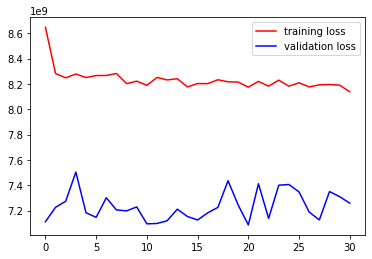

In [21]:
## visualizing the train and validation loss
plt.plot(history.history['loss'],color='red',label='training loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

In [22]:
## Let's load the test data
test = pd.read_csv("/kaggle/input/customer-life-time-prediction/test_koRSKBP.csv")
test.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [23]:
test.isnull().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
dtype: int64

In [24]:
## creating a prediction dataframe
predictions = pd.DataFrame()
predictions['id'] = test['id']

In [25]:
## removing id column from test
test.drop('id',axis=1, inplace=True)

In [26]:
test.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [27]:
for column in test.columns:
    print(f"The unique values in the feature {column} are {test[column].unique()} (Total of {test[column].nunique()}). \n")

The unique values in the feature gender are ['Female' 'Male'] (Total of 2). 

The unique values in the feature area are ['Rural' 'Urban'] (Total of 2). 

The unique values in the feature qualification are ['High School' 'Bachelor' 'Others'] (Total of 3). 

The unique values in the feature income are ['5L-10L' '2L-5L' 'More than 10L' '<=2L'] (Total of 4). 

The unique values in the feature marital_status are [0 1] (Total of 2). 

The unique values in the feature vintage are [6 4 7 2 5 3 8 1 0] (Total of 9). 

The unique values in the feature claim_amount are [ 2134  4102  2925 ... 17238  7829 14603] (Total of 9839). 

The unique values in the feature num_policies are ['More than 1' '1'] (Total of 2). 

The unique values in the feature policy are ['B' 'A' 'C'] (Total of 3). 

The unique values in the feature type_of_policy are ['Silver' 'Platinum' 'Gold'] (Total of 3). 



In [28]:
## replacing outliers from the column claim_amount with the median of the column
quantiles = pd.DataFrame(test['claim_amount']).quantile(np.arange(0,1,0.25)).T
quantiles = quantiles.rename(columns={0.25:'Q1', 0.50: 'Q2', 0.75:'Q3'})

quantiles['IQR'] = quantiles['Q3'] - quantiles['Q1']
quantiles['Lower_Limit'] = quantiles['Q1'] - 1.5*quantiles['IQR']
quantiles['Upper_Limit'] = quantiles['Q3'] + 1.5*quantiles['IQR']

test['claim_amount'] = np.where((test['claim_amount'] < quantiles.loc['claim_amount','Lower_Limit']) | (test['claim_amount'] > quantiles.loc['claim_amount','Upper_Limit']) & (test['claim_amount'] is not np.nan), np.nan, test['claim_amount'])

In [29]:
test

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,Female,Rural,High School,5L-10L,0,6,2134.0,More than 1,B,Silver
1,Female,Urban,High School,2L-5L,0,4,4102.0,More than 1,A,Platinum
2,Male,Rural,High School,5L-10L,1,7,2925.0,More than 1,B,Gold
3,Female,Rural,Bachelor,More than 10L,1,2,0.0,More than 1,B,Silver
4,Female,Urban,High School,2L-5L,0,5,NaN,More than 1,B,Silver
...,...,...,...,...,...,...,...,...,...,...
59590,Male,Rural,Bachelor,5L-10L,1,6,0.0,1,A,Silver
59591,Male,Urban,High School,5L-10L,0,6,0.0,1,C,Gold
59592,Female,Urban,High School,2L-5L,1,4,3323.0,More than 1,B,Platinum
59593,Male,Rural,Bachelor,5L-10L,0,1,2886.0,More than 1,A,Silver


In [30]:
## dealing with the missing values in numerical and categorical features

test['claim_amount'] = imputer1.transform(test['claim_amount'].to_numpy().reshape(-1,1))

for feature in cat_feat + ['vintage', 'marital_status']:
    test[feature] = inputer2.transform(test[feature].to_numpy().reshape(-1,1))

In [31]:
test

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,Female,Rural,High School,5L-10L,0,6,2134.000000,More than 1,B,Silver
1,Female,Urban,High School,2L-5L,0,4,4102.000000,More than 1,A,Platinum
2,Male,Rural,High School,5L-10L,1,7,2925.000000,More than 1,B,Gold
3,Female,Rural,Bachelor,More than 10L,1,2,0.000000,More than 1,B,Silver
4,Female,Urban,High School,2L-5L,0,5,4079.685507,More than 1,B,Silver
...,...,...,...,...,...,...,...,...,...,...
59590,Male,Rural,Bachelor,5L-10L,1,6,0.000000,1,A,Silver
59591,Male,Urban,High School,5L-10L,0,6,0.000000,1,C,Gold
59592,Female,Urban,High School,2L-5L,1,4,3323.000000,More than 1,B,Platinum
59593,Male,Rural,Bachelor,5L-10L,0,1,2886.000000,More than 1,A,Silver


In [32]:
## dealing with the scaling of numerical feature
test['claim_amount'] = mms.transform(test['claim_amount'].to_numpy().reshape(-1,1))
## applying log-transformation to the claim amount feature
test['claim_amount'] = np.log(test['claim_amount'])

## dealing with the encoding of categorical feature
test['income']  = oe1.transform(test['income'].to_numpy().reshape(-1,1))
test['qualification']  = oe2.transform(test['qualification'].to_numpy().reshape(-1,1))
test['type_of_policy']  = oe3.transform(test['type_of_policy'].to_numpy().reshape(-1,1))

transformed=transformer.transform(test)
test=pd.DataFrame(transformed,columns=transformer.get_feature_names_out())

In [33]:
test

,gender_Male,area_Urban,policy_B,policy_C,num_policies_More than 1,qualification,income,marital_status,vintage,claim_amount,type_of_policy
0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,6.0,-1.651645,2.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,-1.023510,1.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,7.0,-1.350554,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,2.0,-4.605170,2.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,-1.028812,2.0
...,...,...,...,...,...,...,...,...,...,...,...
59590,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,-4.605170,2.0
59591,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0,-4.605170,0.0
59592,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,-1.227613,1.0
59593,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.363455,2.0


In [34]:
test

,gender_Male,area_Urban,policy_B,policy_C,num_policies_More than 1,qualification,income,marital_status,vintage,claim_amount,type_of_policy
0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,6.0,-1.651645,2.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,-1.023510,1.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,7.0,-1.350554,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,2.0,-4.605170,2.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,-1.028812,2.0
...,...,...,...,...,...,...,...,...,...,...,...
59590,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,-4.605170,2.0
59591,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0,-4.605170,0.0
59592,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,-1.227613,1.0
59593,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.363455,2.0


In [35]:
test['income'].unique()

array([1., 0., 3., 2.])

In [36]:
test_pred = model.predict(test)

In [37]:
test_pred

array([[ 86751.64 ],
       [124892.8  ],
       [ 87980.664],
       ...,
       [103152.72 ],
       [105443.97 ],
       [113404.664]], dtype=float32)

In [38]:
predictions['cltv'] = test_pred

In [39]:
predictions.head()

,id,cltv
0,89393,86751.640625
1,89394,124892.796875
2,89395,87980.664062
3,89396,86301.375000
4,89397,110483.578125


In [40]:
predictions.to_csv('/kaggle/working/predictions_ann.csv', index=False)